In [1]:
from DeepScence.api import DeepScence
import scanpy as sc
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

我困得要死


#### Read in input data
DeepScence take as input a scanpy anndata object with raw counts stored in `adata.X`. 

In [2]:
counts = pd.read_csv('./origin_matrix_GSE94980.txt', sep = '\t').T
adata = sc.AnnData(counts)
adata.obs['condition'] = [x.split('_')[-1]=='OSKM' for x in adata.obs_names]
adata.obs["SnC"] = (adata.obs["condition"]).astype(int)
adata.X = adata.X.astype(np.float32)

#### Running DeepScence

DeepScence is a convenient one-liner that performs all necessary calculations. DeepScence append 2 additional columns in `adata.obs` as the main results:\
    <br>
    `adata.obs["ds]` is the DeepScence score for each cell;\
    `adata.obs["binary]` is the binarized determination for SnCs (1=True) if user specify `binarize=True`.\
    <br>
Parameter `denoise` is recommended to be set `True`, as it performes count denoising using DCA. Alternatively, user can also perform
denoising on separately. In such cases, make sure the denoised expression matrix is stored in `adata.X` and specify `denoise = False`.

In [3]:
adata = DeepScence(adata, binarize=True, denoise=True)

dca: Successfully preprocessed 16871 genes and 200 cells.



2024-09-29 18:27:23.350879: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-09-29 18:27:23,501 [WARNING] From /Users/lele/Downloads/anaconda3/envs/sene/lib/python3.8/site-packages/dca/train.py:41: The name tf.keras.backend.set_session is deprecated. Please use tf.compat.v1.keras.backend.set_session instead.

2024-09-29 18:27:23.502458: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-29 18:27:23.957351: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:196] None of the MLIR optimization passes are enabled (registered 0 passes)
[2024-09-29 18:27] Input is preprocessed, preprocessed 16871 genes and 200 cells.


dca: Calculating reconstructions...


[2024-09-29 18:27] Using 35 genes in the gene set for scoring
[2024-09-29 18:27] Lambda provided, capturing scores in 2 neurons.
[2024-09-29 18:27] Training on 180 cells, validate on 20 cells.
[2024-09-29 18:27] Binarizing with permutation...
100%|██████████| 50/50 [00:02<00:00, 22.21it/s]
/Users/lele/Downloads/anaconda3/envs/sene/lib/python3.8/site-packages/threadpoolctl.py:1223: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


#### Visualization

Normally you wouldn't have true labels in `adata.obs["SnC]`. For visualization purpose, we compare the predicted results vs. the true labels.

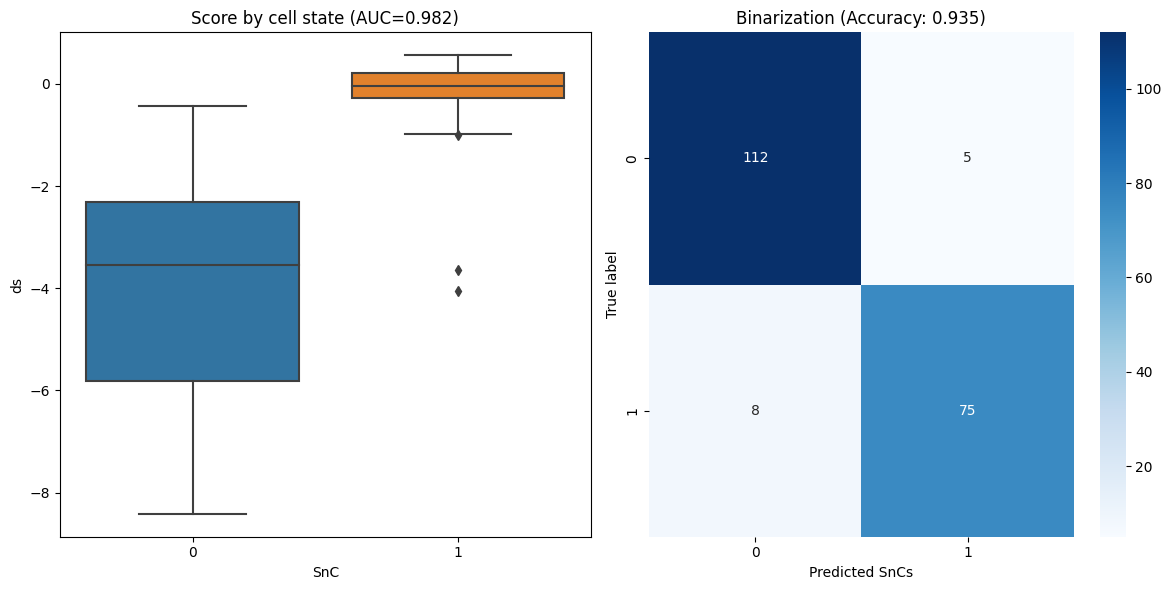

In [4]:
auroc = roc_auc_score(adata.obs["SnC"].values, adata.obs["ds"].values)
accuracy = accuracy_score(adata.obs["binary"], adata.obs["SnC"])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
sns.boxplot(x=adata.obs["SnC"], y=adata.obs["ds"], ax=ax1)
ax1.set_title(f"Score by cell state (AUC={auroc:.3f})")
ax1.set_xlabel("SnC")
ax1.set_ylabel("ds")

cm = confusion_matrix(adata.obs["binary"], adata.obs["SnC"])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2)
ax2.set_title(f"Binarization (Accuracy: {accuracy:.3f})")
ax2.set_xlabel("Predicted SnCs")
ax2.set_ylabel("True label")

plt.tight_layout()
plt.show()